In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import chainer
import chainer.links as L
import chainer.functions as F
from chainer.links import caffe
from chainer.serializers import npz

In [3]:
## save caffemodel needed once
# caffemodel = caffe.CaffeFunction('../../Badmintion/VGG_CNN_M_2048.caffemodel')
# npz.save_npz('VGG_CNN_M_2048.npz', caffemodel, compression=False)

In [4]:
model_npz = np.load('VGG_CNN_M_2048.npz')
print(model_npz.keys())

['conv3/W', 'conv3/b', 'fc8/W', 'fc8/b', 'conv1/W', 'conv1/b', 'conv2/W', 'conv2/b', 'conv5/W', 'conv5/b', 'fc6/W', 'fc6/b', 'conv4/W', 'conv4/b', 'fc7/W', 'fc7/b']


In [5]:
# define MyVGG
class VGG(chainer.Chain):
    def __init__(self, pretrained_model='VGG_CNN_M_2048.npz'):
        super(VGG, self).__init__()
        with self.init_scope():
            self.base = BaseVGG()
            self.fc6 = L.Linear(None, 4096)
            self.fc7 = L.Linear(4096, 2048)
        npz.load_npz(pretrained_model, self.base)
            
    def __call__(self, x):
        h = self.predict(x)
        return h
        
    def predict(self, x):
        h = self.base(x)
        h = F.dropout(F.relu(self.fc6(h)), ratio=.5)
        h = F.dropout(F.relu(self.fc7(h)), ratio=.5)
        return h

In [6]:
# define VGG_CNN_M_2048
class BaseVGG(chainer.Chain):
    def __init__(self):
        super(BaseVGG, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(None, out_channels=96, ksize=7, stride=2)
            self.conv2 = L.Convolution2D(96, out_channels=256, ksize=5, stride=2)
            self.conv3 = L.Convolution2D(256, out_channels=512, ksize=3, pad=1)
            self.conv4 = L.Convolution2D(512, out_channels=512, ksize=3, pad=1)
            self.conv5 = L.Convolution2D(512, out_channels=512, ksize=3, stride=2)
            
    def __call__(self, x):
        h = F.relu(self.conv1(x))
        h = F.local_response_normalization(h, n=5, k=2, alpha=0.0005, beta=0.75)
        h = F.max_pooling_2d(h, ksize=3, stride=2)
        
        h = F.relu(self.conv2(h))
        h = F.local_response_normalization(h, n=5, k=2, alpha=0.0005, beta=0.75)
        h = F.max_pooling_2d(h, ksize=3, stride=2)
        
        h = F.relu(self.conv3(h))
        
        h = F.relu(self.conv4(h))
        
        h = F.relu(self.conv5(h))
        h = F.max_pooling_2d(h, ksize=3, stride=2)
        
        return h

(224, 224, 3)
(1, 3, 224, 224)


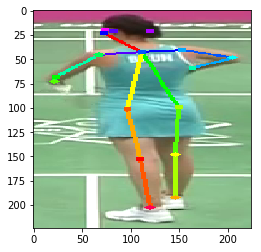

In [7]:
# 入力画像サイズの定義
image_shape = (224, 224)

# 画像を読み込み、RGB形式に変換する
image = Image.open('./data/0/crop_0.png').convert('RGB')
# 画像のリサイズとクリップ
image_w, image_h = image_shape
w, h = image.size
if w > h:
    shape = [image_w * w / h, image_h]
else:
    shape = [image_w, image_h * h / w]
x = (shape[0] - image_w) / 2
y = (shape[1] - image_h) / 2
image = image.resize(image_shape)
#image = image.crop((x, y, x + image_w, y + image_h)) # cropしない
pixels = np.asarray(image).astype(np.float32)
print(pixels.shape)


# pixelsは3次元でそれぞれの軸は[Y座標, X座標, RGB]を表す
# 入力データは4次元で[画像インデックス, BGR, Y座標, X座標]なので、配列の変換を行う
# RGBからBGRに変換する
pixels = pixels[:,:,::-1]

# 軸を入れ替える
pixels = pixels.transpose(2,0,1)

# 平均画像を引く
mean_image = np.ndarray((3, 224, 224), dtype=np.float32)
mean_image[0] = 103.939
mean_image[1] = 116.779
mean_image[2] = 123.68
pixels -= mean_image

# 4次元にする
pixels = pixels.reshape((1,) + pixels.shape)
plt.imshow(image)
print(pixels.shape)

In [11]:
# check the outputs of VGG
model = VGG()

y = model(pixels)
print(y.shape)
y = F.softmax(y).data
y.max(axis=1)

(1, 2048)


array([ 0.39614961], dtype=float32)

In [109]:
# disable to learn weght in baseVGG
model = VGG()
optimizer = chainer.optimizers.MomentumSGD()
optimizer.setup(model)
model.base.disable_update()

In [119]:
y = model(pixels)
y = F.softmax(y).data
y.max(axis=1)

array([ 0.72818965], dtype=float32)

# ED-TCN keras

define model

In [16]:
import os
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Input, Dense, TimeDistributed, merge, Lambda
from keras.layers.core import *
from keras.layers.convolutional import *
from keras.layers.recurrent import *

import tensorflow as tf
from keras import backend as K

from keras.activations import relu

In [ ]:
def ED_TCN(n_nodes, conv_len, n_classes, n_feat, max_len, 
            loss='categorical_crossentropy', causal=False, 
            optimizer="rmsprop", activation='norm_relu',
            return_param_str=False):
    n_layers = len(n_nodes)

    inputs = Input(shape=(max_len,n_feat))
    model = inputs

    # ---- Encoder ----
    for i in range(n_layers):
        # Pad beginning of sequence to prevent usage of future data
        if causal: model = ZeroPadding1D((conv_len//2,0))(model)
        model = Convolution1D(n_nodes[i], conv_len, border_mode='same')(model)
        if causal: model = Cropping1D((0,conv_len//2))(model)

        model = SpatialDropout1D(0.3)(model)
        
        if activation=='norm_relu': 
            model = Activation('relu')(model)            
            model = Lambda(channel_normalization, name="encoder_norm_{}".format(i))(model)
        elif activation=='wavenet': 
            model = WaveNet_activation(model) 
        else:
            model = Activation(activation)(model)            
        
        model = MaxPooling1D(2)(model)

    # ---- Decoder ----
    for i in range(n_layers):
        model = UpSampling1D(2)(model)
        if causal: model = ZeroPadding1D((conv_len//2,0))(model)
        model = Convolution1D(n_nodes[-i-1], conv_len, border_mode='same')(model)
        if causal: model = Cropping1D((0,conv_len//2))(model)

        model = SpatialDropout1D(0.3)(model)

        if activation=='norm_relu': 
            model = Activation('relu')(model)
            model = Lambda(channel_normalization, name="decoder_norm_{}".format(i))(model)
        elif activation=='wavenet': 
            model = WaveNet_activation(model) 
        else:
            model = Activation(activation)(model)
            
    # Output FC layer
    model = TimeDistributed(Dense(n_classes, activation="softmax" ))(model)
    
    model = Model(input=inputs, output=model)
    model.compile(loss=loss, optimizer=optimizer, sample_weight_mode="temporal", metrics=['accuracy'])

    if return_param_str:
        param_str = "ED-TCN_C{}_L{}".format(conv_len, n_layers)
        if causal:
            param_str += "_causal"
    
        return model, param_str
    else:
        return model

implementation

In [ ]:
# ---------- Directories & User inputs --------------
# Location of data/features folder
base_dir = os.path.expanduser("~/TCN_release/")

save_predictions = [False, True][1]
viz_predictions = [False, True][1]
viz_weights = [False, True][0]

# Set dataset and action label granularity (if applicable)
# dataset = ["50Salads", "JIGSAWS", "MERL", "GTEA"][0]
# granularity = ["eval", "mid"][1]
sensor_type = ["video", "sensors"][0]

# Set model and parameters
model_type = ["SVM", "LSTM", "LC-SC-CRF", "tCNN",  "DilatedTCN", "ED-TCN", "TDNN"][5]
# causal or acausal? (If acausal use Bidirectional LSTM)
causal = [False, True][0]

# How many latent states/nodes per layer of network
# Only applicable to the TCNs. The ECCV and LSTM  model suses the first element from this list.
n_nodes = [64, 96]
nb_epoch = 200
video_rate = 3
conv = {'50Salads':25, "JIGSAWS":20, "MERL":5, "GTEA":25}[dataset]

# Which features for the given dataset
features = "SpatialCNN"
bg_class = 0 if dataset is not "JIGSAWS" else None

if dataset == "50Salads":
    features = "SpatialCNN_" + granularity

In [19]:
# ------------------------------------------------------------------

# Initialize dataset loader & metrics
# data = datasets.Dataset(dataset, base_dir)
trial_metrics = metrics.ComputeMetrics(overlap=.1, bg_class=bg_class)

# Load data for each split
for split in data.splits:
    if sensor_type=="video":
        feature_type = "A" if model_type != "SVM" else "X"
    else:
        feature_type = "S"

    X_train, y_train, X_test, y_test = data.load_split(features, split=split, 
                                                        sample_rate=video_rate, 
                                                        feature_type=feature_type)

    if trial_metrics.n_classes is None:
        trial_metrics.set_classes(data.n_classes)

    n_classes = data.n_classes
    train_lengths = [x.shape[0] for x in X_train]
    test_lengths = [x.shape[0] for x in X_test]
    n_train = len(X_train)
    n_test = len(X_test)

    n_feat = data.n_features
    print("# Feat:", n_feat)

    # ------------------ Models ----------------------------
    if model_type == "SVM":
        svm = LinearSVC()
        svm.fit(np.vstack(X_train), np.hstack(y_train))
        P_test = [svm.predict(x) for x in X_test]

        # AP_x contains the per-frame probabilities (or class) for each class
        AP_train = [svm.decision_function(x) for x in X_train]
        AP_test = [svm.decision_function(x) for x in X_test]
        param_str = "SVM"

    # --------- CVPR model ----------
    elif model_type in ["tCNN", "ED-TCN", "DilatedTCN", "TDNN", "LSTM"]:
        # Go from y_t = {1...C} to one-hot vector (e.g. y_t = [0, 0, 1, 0])
        Y_train = [np_utils.to_categorical(y, n_classes) for y in y_train]
        Y_test = [np_utils.to_categorical(y, n_classes) for y in y_test]

        # In order process batches simultaneously all data needs to be of the same length
        # So make all same length and mask out the ends of each.
        n_layers = len(n_nodes)
        max_len = max(np.max(train_lengths), np.max(test_lengths))
        max_len = int(np.ceil(max_len / (2**n_layers)))*2**n_layers
        print("Max length:", max_len)

        X_train_m, Y_train_, M_train = utils.mask_data(X_train, Y_train, max_len, mask_value=-1)
        X_test_m, Y_test_, M_test = utils.mask_data(X_test, Y_test, max_len, mask_value=-1)

        if model_type == "tCNN":
            model, param_str = tf_models.temporal_convs_linear(n_nodes[0], conv, n_classes, n_feat, 
                                                max_len, causal=causal, return_param_str=True)
        elif model_type == "ED-TCN":
            model, param_str = tf_models.ED_TCN(n_nodes, conv, n_classes, n_feat, max_len, causal=causal, 
                                    activation='norm_relu', return_param_str=True) 
            # model, param_str = tf_models.ED_TCN_atrous(n_nodes, conv, n_classes, n_feat, max_len, 
                                # causal=causal, activation='norm_relu', return_param_str=True)                 
        elif model_type == "TDNN":
            model, param_str = tf_models.TimeDelayNeuralNetwork(n_nodes, conv, n_classes, n_feat, max_len, 
                               causal=causal, activation='tanh', return_param_str=True)
        elif model_type == "DilatedTCN":
            model, param_str = tf_models.Dilated_TCN(n_feat, n_classes, n_nodes[0], L, B, max_len=max_len, 
                                    causal=causal, return_param_str=True)
        elif model_type == "LSTM":
            model, param_str = tf_models.BidirLSTM(n_nodes[0], n_classes, n_feat, causal=causal, return_param_str=True)

        model.fit(X_train_m, Y_train_, nb_epoch=nb_epoch, batch_size=8,
                    verbose=1, sample_weight=M_train[:,:,0]) 

        AP_train = model.predict(X_train_m, verbose=0)
        AP_test = model.predict(X_test_m, verbose=0)
        AP_train = utils.unmask(AP_train, M_train)
        AP_test = utils.unmask(AP_test, M_test)

        P_train = [p.argmax(1) for p in AP_train]
        P_test = [p.argmax(1) for p in AP_test]

    # --------- ICRA model ----------
    elif model_type == 'LC-SC-CRF':
        try:
            from LCTM import models
        except:
            print("Error: LCTM not installed")
            print("For more info: https://github.com/colincsl/LCTM")
            break
        X_train_T = [x.T for x in X_train]
        X_test_T = [x.T for x in X_test]
        n_latent_per_class = 4 
        skip = conv
        model = models.LatentConvModel(n_latent=n_latent_per_class, conv_len=conv, skip=skip, prior=True, debug=True)
        model.fit(X_train_T, y_train, n_iter=200, learning_rate=.1, pretrain=True, verbose=True)
        model.filter_len = conv//2+1 if conv>1 else 1
        P_test = model.predict(X_test_T, inference="filtered")
        AP_train = [x.T for x in model.decision_function(X_train_T)]
        AP_test = [x.T for x in model.decision_function(X_test_T)]

        param_str = "LC-SC-CRF_C{}_S{}_I{}".format(conv, skip, model.inference_type)

    # --------- DTW baseline model ----------
    elif model_type == "DTW":
        try:
            import DTW
        except:
            print("Error: DTW not installed")
            print("For more info: https://github.com/colincsl/LCTM")
            break        

        P_test = []
        for i in range(n_test):
            dists, preds = [], []
            for j in range(n_train):
                dist, c = DTW(X_train[j], X_test[i], output_correspondences=True)
                dists += [dist]
                preds += [y_train[j][c]]
            idx_best = np.argmin(dists)
            P_test += [preds[idx_best]]

    else:
        print("Model not available:", model_type)

    param_str = "_".join([granularity, sensor_type, param_str])
    print(param_str)

    # --------- Metrics ----------    
    trial_metrics.add_predictions(split, P_test, y_test)       
    trial_metrics.print_trials()
    print()

    # ----- Save predictions -----
    if save_predictions:
        dir_out = os.path.expanduser(base_dir+"/predictions/{}/{}/".format(dataset,param_str))

        # Make sure folder exists
        if not os.path.isdir(dir_out):
            os.makedirs(dir_out)

        out = {"P":P_test, "Y":y_test, "S":AP_test}
        sio.savemat( dir_out+"/{}.mat".format(split), out)      

    # ---- Viz predictions -----
    if viz_predictions:
        max_classes = data.n_classes - 1
        # # Output all truth/prediction pairs
        plt.figure(split, figsize=(20,10))
        P_test_ = np.array(P_test)/float(n_classes-1)
        y_test_ = np.array(y_test)/float(n_classes-1)
        for i in range(len(y_test)):
            P_tmp = np.vstack([y_test_[i], P_test_[i]])
            plt.subplot(n_test,1,i+1); imshow_(P_tmp, vmin=0, vmax=1)
            plt.xticks([])
            plt.yticks([])
            acc = np.mean(y_test[i]==P_test[i])*100
            plt.ylabel("{:.01f}".format(acc))
            # plt.title("Acc: {:.03}%".format(100*np.mean(P_test[i]==y_test[i])))

    # ---- Viz weights -----
    if viz_weights and model_type is "TCN":
        # Output weights at the first layer
        plt.figure(2, figsize=(15,15))
        ws = model.get_weights()[0]
        for i in range(min(36, len(ws.T))):
            plt.subplot(6,6,i+1)
            # imshow_(model.get_weights()[0][i][:,:,0]+model.get_weights()[1][i])
            imshow_(np.squeeze(ws[:,:,:,i]).T)
            # Output weights at the first layer

        for l in range(2*n_layers):
            plt.figure(l+1, figsize=(15,15))
            ws = model.get_weights()[l*2]
            for i in range(min(36, len(ws.T))):
                plt.subplot(6,6,i+1)
                # imshow_(model.get_weights()[0][i][:,:,0]+model.get_weights()[1][i])
                imshow_(np.squeeze(ws[:,:,:,i]).T)
                # Output weights at the first layer

    print()
    trial_metrics.print_scores()
    trial_metrics.print_trials()
    print()



True